Ported to Python (by Ilan Fridman Rojas) from original R implementation by Rasmus Bååth:
http://www.sumsar.net/blog/2015/07/easy-bayesian-bootstrap-in-r/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
data = pd.read_csv('american_presidents.csv', header=0, index_col=None)
data

,order,president,height_cm
0,1,George Washington,188.0
1,2,John Adams,170.0
2,3,Thomas Jefferson,189.0
3,4,James Madison,163.0
4,5,James Monroe,183.0
5,6,John Quincy Adams,171.0
6,7,Andrew Jackson,185.0
7,8,Martin Van Buren,168.0
8,9,William Henry Harrison,173.0
9,10,John Tyler,183.0


In [3]:
data.describe()

,order,height_cm
count,43.000000,43.00000
mean,22.465116,179.80000
std,12.995143,6.92999
min,1.000000,163.00000
25%,11.500000,174.50000
50%,22.000000,182.00000
75%,33.500000,184.00000
max,44.000000,192.40000


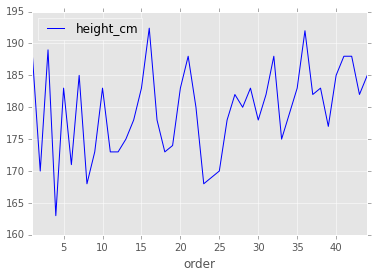

In [4]:
data.plot(x='order',y='height_cm', color='blue')

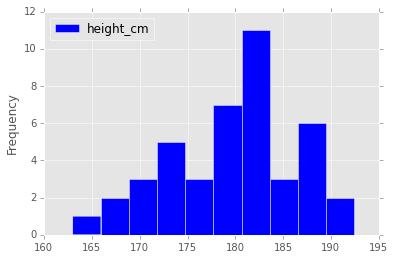

In [5]:
data.plot('order', kind='hist', color='blue')

In [6]:
import random
import numpy.random as npr

The standard bootstrap method

In [7]:
def bootstrap(data, num_samples, statistic, alpha):
    """Returns the results from num_samples bootstrap samples for an input test statistic and its 100*(1-alpha)% confidence level interval."""
    # Generate the indices for the required number of permutations/(resamplings with replacement) required
    idx = npr.randint(0, len(data), (num_samples, len(data)))
    # Generate the multiple resampled data set from the original one
    samples = data[idx]
    # Apply the 'statistic' function given to each of the data sets produced by the resampling and order the resulting statistic by decreasing size.
    stats = np.sort(statistic(samples, 1))
    stat = stats.mean()
    # Return the value of the computed statistic at the upper and lower percentiles specified by the alpha parameter given. These are, by definition, the boundaries of the Confidence Interval for that value of alpha. E.g. alpha=0.05 ==> CI 95%
    low_ci = stats[int((alpha / 2.0) * num_samples)]
    high_ci = stats[int((1 - alpha / 2.0) * num_samples)]

    #sd = np.std(stat)
    # To include Bessel's correction for unbiased standard deviation:
    sd = np.std(stat, ddof=1)
    # or manually:
    # sd = np.sqrt(len(data) / (len(data) - 1)) * np.std(stats)
    return stat, sd, low_ci, high_ci


The Bayesian bootstrap (with a Dirichlet prior)

(See:
http://sumsar.net/blog/2015/04/the-non-parametric-bootstrap-as-a-bayesian-model/
and
http://projecteuclid.org/euclid.aos/1176345338
)

In [8]:
def bayes_bstrp(data, statistic, nbstrp, samplesize):
    """Implements the Bayesian bootstrap method."""
    
    def Dirichlet_sample(m,n):
        """Returns a matrix of values drawn from a Dirichlet distribution with parameters = 1.
        'm' rows of values, with 'n' Dirichlet draws in each one."""
        # Draw from Gamma distribution
        Dirichlet_params = np.ones(m*n) # Set Dirichlet distribution parameters
        # https://en.wikipedia.org/wiki/Dirichlet_distribution#Gamma_distribution
        Dirichlet_weights = np.asarray([random.gammavariate(a,1) for a in Dirichlet_params])
        Dirichlet_weights = Dirichlet_weights.reshape(m,n) # Fold them (row by row) into a matrix
        row_sums = Dirichlet_weights.sum(axis=1)
        Dirichlet_weights = Dirichlet_weights / row_sums[:, np.newaxis] # Reweight each row to be normalised to 1
        return Dirichlet_weights
    
    Dirich_wgts_matrix = Dirichlet_sample(nbstrp, data.shape[0]) #Generate sample of Dirichlet weights
    
    # If statistic can be directly computed using the weights (such as the mean), do this since it will be faster.
    if statistic==np.mean or statistic==np.average:
        results = np.asarray([np.average(data, weights=Dirich_wgts_matrix[i]) for i in xrange(nbstrp)])
        return results
    
    # Otherwise resort to sampling according to the Dirichlet weights and computing the statistic
    else:
        results = np.zeros(nbstrp)
        for i in xrange(nbstrp): #Sample from data according to Dirichlet weights
            weighted_sample = np.random.choice(data, samplesize, replace=True, p = Dirich_wgts_matrix[i])
            results[i] = statistic(weighted_sample) #Compute the statistic for each sample
        return results

Test both the weighted statistic method and the weighted sampling methods

In [9]:
height_data = data['height_cm'].values

posterior_mean = bayes_bstrp(height_data, np.mean, nbstrp=10000, samplesize=1000)
print posterior_mean

posterior_median = bayes_bstrp(height_data, np.median, nbstrp=10000, samplesize=1000)
print posterior_median

[ 180.85647367  179.98984525  180.99295606 ...,  180.57419551  179.89039703
  179.12630132]
[ 178.  182.  178. ...,  182.  183.  180.]


Define a function to compute confidence intervals and use it

In [10]:
def CI(sample, alpha=0.05):
    """Returns the 100*(1-alpha)% confidence level interval for a test statistic computed on a bootstrap sample."""
    sample.sort()
    num_samples = sample.shape[0]
    low_ci = sample[int((alpha / 2.0) * num_samples)]
    high_ci = sample[int((1 - alpha / 2.0) * num_samples)]
    return [low_ci, high_ci]

In [11]:
meanCI = CI(posterior_mean, alpha=0.05)

print "The mean of the posterior is:\t{0:.4g}".format(posterior_mean.mean())
print "With confidence interval:\t[{0:.4g}, {1:.4g}]".format(meanCI[0],meanCI[1])
#print posterior_median.mean(), CI(posterior_median)

The mean of the posterior is:	179.8
With confidence interval:	[177.8, 181.8]


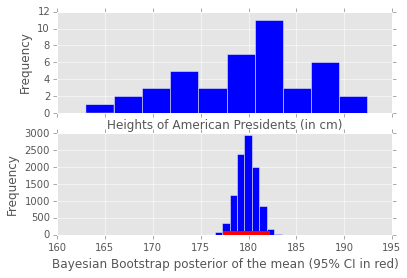

In [12]:
fig,ax =plt.subplots(2,1, sharex=True)
ax[0].hist(height_data, color='blue')
ax[0].set_xlabel('Heights of American Presidents (in cm)')
ax[0].set_ylabel('Frequency')
ax[1].hist(posterior_mean, color='blue')
ax[1].set_xlabel('Bayesian Bootstrap posterior of the mean (95% CI in red)')
ax[1].set_ylabel('Frequency')
ax[1].plot([meanCI[0], meanCI[1]], [0, 0], 'r', linewidth=8)
plt.show()

In [13]:
from scipy import stats

x = data['order'].values
y = data['height_cm'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print slope
print intercept

0.190421199662
175.522165608


In [14]:
def bayes_bstrp1(data, statistic, nbstrp, samplesize):
    """Implements the Bayesian bootstrap method."""
    """Input can be a 1D Numpy array, or for test statistics of two variables: a Pandas DataFrame with two columns: x,y"""
    
    def Dirichlet_sample(m,n):
        """Returns a matrix of values drawn from a Dirichlet distribution with parameters = 1.
        'm' rows of values, with 'n' Dirichlet draws in each one."""
        Dirichlet_params = np.ones(m*n) # Set Dirichlet distribution parameters
        # https://en.wikipedia.org/wiki/Dirichlet_distribution#Gamma_distribution
        Dirichlet_weights = np.asarray([random.gammavariate(a,1) for a in Dirichlet_params]) # Draw from Gamma distrib
        Dirichlet_weights = Dirichlet_weights.reshape(m,n) # Fold them (row by row) into a matrix
        row_sums = Dirichlet_weights.sum(axis=1)
        Dirichlet_weights = Dirichlet_weights / row_sums[:, np.newaxis] # Reweight each row to be normalised to 1
        return Dirichlet_weights
    
    Dirich_wgts_matrix = Dirichlet_sample(nbstrp, data.shape[0]) #Generate sample of Dirichlet weights

    if data.ndim==1:
        # If statistic can be directly computed using the weights (such as the mean), do this since it will be faster.
        if statistic==np.mean or statistic==np.average:
            results = np.asarray([np.average(data, weights=Dirich_wgts_matrix[i]) for i in xrange(nbstrp)])
            return results

        # Otherwise resort to sampling according to the Dirichlet weights and computing the statistic
        else:
            results = np.zeros(nbstrp)
            for i in xrange(nbstrp): #Sample from data according to Dirichlet weights
                weighted_sample = np.random.choice(data, samplesize, replace=True, p = Dirich_wgts_matrix[i])
                results[i] = statistic(weighted_sample) #Compute the statistic for each sample
            return results
        
    elif data.ndim>=2:
        # If statistic can be directly computed using the weights (such as the mean), do this since it will be faster.
        if statistic==np.mean or statistic==np.average:
            results = np.asarray([np.average(data[data.columns[1]].values, weights=Dirich_wgts_matrix[i])
                                  for i in xrange(nbstrp)])
            return results

        # Otherwise resort to sampling according to the Dirichlet weights and computing the statistic
        else:
            index_sample=np.zeros((nbstrp,samplesize))
            results = []
            for i in xrange(nbstrp): #Sample from data according to Dirichlet weights
                # Now instead of sampling data points directly, we sample over their index (i.e. by row number)
                #   which is exactly equivalent, but which preserves the x,y pairings during the sampling
                index_sample[i,:] = np.random.choice(np.arange(data.shape[0]), samplesize, replace=True,
                                                     p = Dirich_wgts_matrix[i])
                # We index from the DataFrame this way because Pandas does not support slicing like this
                #    http://stackoverflow.com/questions/23686561/slice-a-pandas-dataframe-by-an-array-of-indices-and-column-names
                results.append(statistic(data.values[index_sample[i].astype(int),0],
                                         data.values[index_sample[i].astype(int),1]))
            return np.array(results)
        

In [15]:
posterior_mean1 = bayes_bstrp1(height_data, np.mean, nbstrp=10000, samplesize=1000)
print posterior_mean1

posterior_median1 = bayes_bstrp(height_data, np.median, nbstrp=10000, samplesize=1000)
print posterior_median1

[ 181.11346261  180.77468872  178.24935833 ...,  179.46000732  179.11265521
  177.70297528]
[ 180.  182.  183. ...,  178.  180.  182.]


In [16]:
# Copy the columns containing x and y (in that order) into a new Pandas DataFrame, to be used for Bayesian bootstrap
test_df = data[['order','height_cm']]

linregres_posterior = bayes_bstrp1(test_df, stats.linregress, nbstrp=100, samplesize=60)
print linregres_posterior

# These 5 values are:     slope, intercept, R, p_value, std_err

[[  2.01722837e-01   1.74321119e+02   3.67077485e-01   3.91402030e-03
    6.71204967e-02]
 [  2.27692509e-01   1.74763637e+02   4.88110673e-01   7.61442295e-05
    5.34591556e-02]
 [  1.80608218e-01   1.77098241e+02   3.18364141e-01   1.31738061e-02
    7.06143997e-02]
 [  2.22044410e-01   1.76341450e+02   3.43056525e-01   7.28849159e-03
    7.98309524e-02]
 [  4.15536778e-02   1.78792609e+02   8.46444311e-02   5.20213622e-01
    6.42296700e-02]
 [  2.42152442e-01   1.75097101e+02   4.62582509e-01   1.98252382e-04
    6.09398997e-02]
 [  2.96015796e-01   1.73909220e+02   5.80211704e-01   1.18062472e-06
    5.45616134e-02]
 [  1.89729051e-01   1.75443151e+02   4.22153872e-01   7.80159543e-04
    5.34968804e-02]
 [  3.26460404e-01   1.71487355e+02   5.45480954e-01   6.57239929e-06
    6.58634989e-02]
 [  1.46836965e-01   1.76659420e+02   3.14389413e-01   1.44289548e-02
    5.82175968e-02]
 [  3.42558177e-01   1.70210003e+02   5.97927395e-01   4.54475086e-07
    6.02979647e-02]
 [  9.9967

Below we apply the -Bayesian, but could just as well be classical- bootstrap method to a linear regression by bootstrapping the data.

This is not the only way to apply the bootstrap. One could fix the regressors/covariates $x_i$, as well as the regression coefficients, $\mathbf{\beta}$, of the linear fit to the original dataset, and then bootstrap the residuals $y_i - \hat{y}_i(\mathbf{\beta})$. The former approach is expected to be more conservative (give larger confidence intervals) than the latter, which is more model dependent in that it fixes the coefficients and thereby implicitly assumes the linear model is essentially correct and only the random variation/noise of the data needs to be bootstrapped.

For more on this see the corresponding section in the original work:
https://books.google.co.uk/books?id=gLlpIUxRntoC&lpg=PA113&ots=A8xyY7Lcz3&dq=regression%20bootstrap%20data%20or%20residuals&pg=PA113#v=onepage&q=regression%20bootstrap%20data%20or%20residuals&f=false

For a short, concise and clear explanation of the pros and cons of each way of bootstrapping regression models see:
http://www.stat.cmu.edu/~cshalizi/uADA/13/lectures/which-bootstrap-when.pdf

In [17]:
slopes = linregres_posterior[:,0]
slopemean = slopes.mean()
slopeCI = CI(slopes)
print "The mean slope and its 95% CI are:\t{0:.4g}\t\t[{1:.4g}, {2:.4g}]".format(slopemean,slopeCI[0],slopeCI[1])

intercepts = linregres_posterior[:,1]
interceptmean = intercept.mean()
interceptCI = CI(intercepts)
print "The mean intercept and its 95% CI are:\t{0:.4g}\t\t[{1:.4g}, {2:.4g}]".format(interceptmean,interceptCI[0],
                                                                                     interceptCI[1])

The mean slope and its 95% CI are:	0.1923		[-0.01266, 0.4148]
The mean intercept and its 95% CI are:	175.5		[169.8, 182.1]


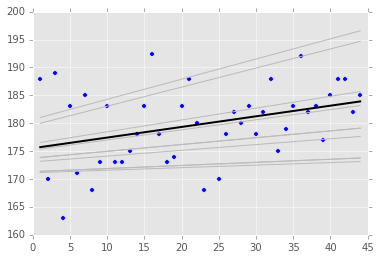

In [18]:
# Plot the data points
plt.scatter(data['order'].values, data['height_cm'].values)

# The linear function we will use to plot fit coefficients
def linfit(x,slope,intercept):
    return slope*x + intercept

x = data['order'].values
y = data['height_cm'].values

# Choose linear regressions for 10 of the bootstrap samples at random and plot them
ids = npr.randint(0, linregres_posterior.shape[0], 10)
otherfits = [linfit(x, linregres_posterior[i,0], linregres_posterior[i,1]) for i in ids]
for i in otherfits:
    plt.plot(x, i, color='#BBBBBB')

# The fit to the original data
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.plot(x, linfit(x, slope, intercept), color='black', linewidth=2)
    
plt.xlim(0,x.max()+1)
plt.show()

From this plot and the confidence interval on the slope we can confidently say that there is no evidence for a correlation between the two variables.

In [19]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# for some odd reason this loess function takes the y values as the first argument and x as second
test_df = data[['height_cm', 'order']]

posterior_loess = bayes_bstrp1(test_df, lowess, nbstrp=100, samplesize=60)
print posterior_loess

[[[   1.          161.2307358 ]
  [   1.          161.2307358 ]
  [   2.          162.35369256]
  ..., 
  [  36.          184.17097231]
  [  41.          185.58310123]
  [  43.          186.14808695]]

 [[   3.          176.41936072]
  [   4.          176.5736097 ]
  [   5.          176.75774602]
  ..., 
  [  41.          186.72177553]
  [  42.          187.26463385]
  [  42.          187.26463385]]

 [[   1.          185.94217611]
  [   1.          185.94217611]
  [   5.          185.01111205]
  ..., 
  [  41.          186.00813983]
  [  41.          186.00813983]
  [  41.          186.00813983]]

 ..., 
 [[   4.          170.58522278]
  [   4.          170.58522278]
  [   5.          171.18383756]
  ..., 
  [  42.          185.90205238]
  [  42.          185.90205238]
  [  44.          186.77333643]]

 [[   1.          175.28475106]
  [   1.          175.28475106]
  [   1.          175.28475106]
  ..., 
  [  42.          185.44462395]
  [  42.          185.44462395]
  [  42.         

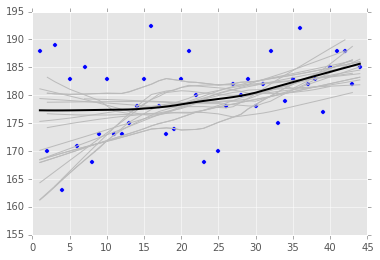

In [20]:
x = data['order'].values
y = data['height_cm'].values

# To see all the loess curves found:
#for i in posterior_loess:
#    plt.plot(i[:,0], i[:,1], color='#BBBBBB')

ids = npr.randint(0, posterior_loess.shape[0], 20)
for i in ids:
    plt.plot(posterior_loess[i,:,0], posterior_loess[i,:,1], color='#BBBBBB')

plt.scatter(x, y)
    
original_loess = lowess(y, x)
plt.plot(original_loess[:,0], original_loess[:,1], color='black', linewidth=2)
    
plt.xlim(0,x.max()+1)
plt.show()